In [49]:
import gc
import implicit
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import svds
from tqdm import tqdm

### 1. Загрузка данных

В качестве экспериментальных данных выбран малый набор данных Digital Music. Источник: https://nijianmo.github.io/amazon/index.html

In [50]:
df = pd.read_csv("data/Digital_Music.csv")
df.head()

,item,user,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


### 2. EDA

In [51]:
df.describe()

,rating,timestamp
count,1.584082e+06,1.584082e+06
mean,4.660555e+00,1.408211e+09
std,8.440314e-01,7.857646e+07
min,1.000000e+00,8.773056e+08
25%,5.000000e+00,1.374883e+09
50%,5.000000e+00,1.420070e+09
75%,5.000000e+00,1.457222e+09
max,5.000000e+00,1.538438e+09


In [52]:
df.shape

(1584082, 4)

In [53]:
df.isna().sum()

item         0
user         0
rating       0
timestamp    0
dtype: int64

In [54]:
df[df.duplicated()]

,item,user,rating,timestamp
178,0760103453,A3DDHWGLHXS9DK,4.0,1361750400
2620,9714721180,A262TFY27XMQS3,5.0,1135123200
3916,B000007UVW,A2J2LSLU2EJMA6,5.0,956016000
3918,B000007UVW,A2D4MJ06A9UHE5,5.0,949276800
4673,B00004YKE2,ASI1E3YT1QSSD,5.0,1036886400
...,...,...,...,...
1571546,B01F31H2J2,A3IY9HIAMJQ7HL,4.0,1468108800
1576555,B01G473PR2,APFPBV1WMGQEI,5.0,1485216000
1577366,B01G8IEPQW,A25YUMUDUUL9KD,5.0,1473984000
1582008,B01H6J07BY,A2LH31WCHOB2YQ,5.0,1473120000


In [55]:
df.drop_duplicates()

,item,user,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400
...,...,...,...,...
1584077,B01HJ91P94,AR3KABMPL5L0O,5.0,1520035200
1584078,B01HJ91P94,A2N53GHW73INDH,4.0,1516752000
1584079,B01HJ91P94,ABNKLDCCVJKW1,5.0,1492732800
1584080,B01HJ91IVY,AMWSDABZWFRAT,5.0,1519344000


In [56]:
df['user'].nunique()

840372

In [57]:
df['item'].nunique()

456992

In [58]:
from datetime import datetime

In [59]:
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [60]:
df.head()

,item,user,rating,timestamp,date
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400,2013-12-22 03:00:00
1,0001388703,AC2PL52NKPL29,5.0,1378857600,2013-09-11 03:00:00
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400,2013-03-02 03:00:00
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400,2012-12-02 03:00:00
4,0001388703,A12R54MKO17TW0,5.0,1325894400,2012-01-07 03:00:00


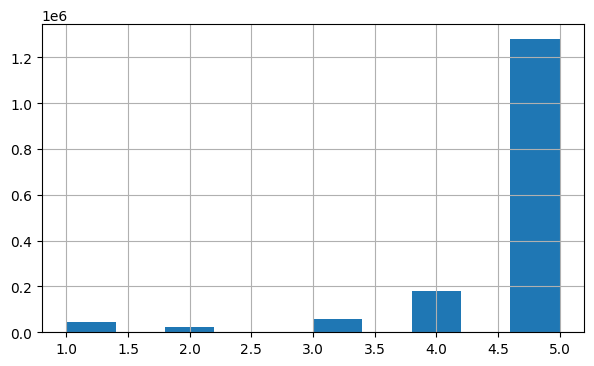

In [61]:
df['rating'].hist(bins=10, figsize=(7, 4));

Распределение райтингов выглядит как и ожидалось: покупатели больше склонны оценивать что-либо в случае, если это что-либо вызвало положительную реакцию (эмоцию) 

In [62]:
df['rating'].value_counts()

rating
5.0    1280147
4.0     179929
3.0      57347
1.0      43108
2.0      23551
Name: count, dtype: int64

Количество товаров, оцененных покупателем

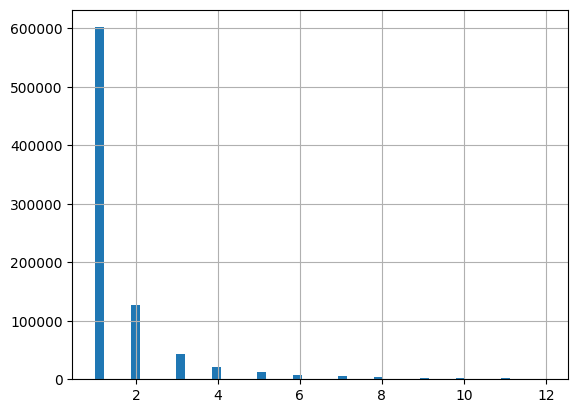

In [63]:
buyer_groups = df.groupby('user')['item'].count()
buyer_groups[buyer_groups < buyer_groups.quantile(0.99)].hist(bins=50);

Количество покупателей, оценивших конкретный товар

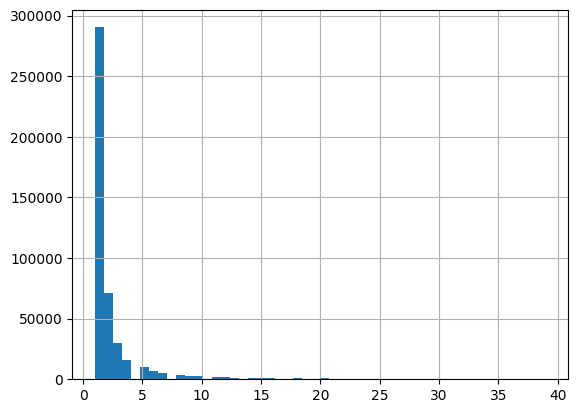

In [64]:
buyer_groups = df.groupby('item')['user'].count()
buyer_groups[buyer_groups < buyer_groups.quantile(0.99)].hist(bins=50);

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   item       1584082 non-null  object        
 1   user       1584082 non-null  object        
 2   rating     1584082 non-null  float64       
 3   timestamp  1584082 non-null  int64         
 4   date       1584082 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 60.4+ MB


### 3. ALS модель

In [66]:
model = implicit.als.AlternatingLeastSquares(factors=50)

In [67]:
unique_users = df["user"].unique()
unique_users

array(['A1ZCPG3D3HGRSS', 'AC2PL52NKPL29', 'A1SUZXBDZSDQ3A', ...,
       'AR3KABMPL5L0O', 'A2N53GHW73INDH', 'ABNKLDCCVJKW1'], dtype=object)

In [68]:
user_ids = dict (zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))
user_ids

{'A1ZCPG3D3HGRSS': 0,
 'AC2PL52NKPL29': 1,
 'A1SUZXBDZSDQ3A': 2,
 'A3A0W7FZXM0IZW': 3,
 'A12R54MKO17TW0': 4,
 'A25ZT87OMIPLNX': 5,
 'A3NVGWKHLULDHR': 6,
 'AT7OB43GHKIUA': 7,
 'A1H3X1TW6Y7HD8': 8,
 'AZ3T21W6CW0MW': 9,
 'A2W6V65OFOZ12M': 10,
 'A1DOF5GHOWGMW6': 11,
 'A4V08BR7LZ6D9': 12,
 'AJO3UG6FR5C7R': 13,
 'A106GSY0H5E2R4': 14,
 'A33D2MKED6ZENS': 15,
 'A27P44I54RUMDC': 16,
 'A2A3M3HVVGT9XY': 17,
 'A2HVNCQUR2J4NL': 18,
 'A50DSLM71EAVO': 19,
 'A33NJBWHVS6HKX': 20,
 'A3BQ84G90BRVSG': 21,
 'A150DKJ7BD9A4L': 22,
 'A3FGRMZ485P2HU': 23,
 'AVOX1HMLM58C': 24,
 'A3HDIAWLEPA2KD': 25,
 'AGZCVUB1FHMR': 26,
 'A3MNMIWVCAL30D': 27,
 'A7VXJ1FWJUP3V': 28,
 'A11WZIXPXPDZ5R': 29,
 'A26A8B3HRRWTRZ': 30,
 'A1ZFAYDQE9YQ9O': 31,
 'AIRWWB582E4RZ': 32,
 'A1W23DEQW7ZK19': 33,
 'ATKKLECFEOMZA': 34,
 'A6WJJ5M51EQGF': 35,
 'A3INJI4T4U2JJS': 36,
 'AUUKQM9AD6RP8': 37,
 'A1JBYBGDDNO51O': 38,
 'A3S6XIJMIBMWFL': 39,
 'A269LWI1OWLFJC': 40,
 'ARHTBEWBVZSBW': 41,
 'A337XLTS4D4KKS': 42,
 'A1RC7VZJPMCFTJ': 43,
 'A57N3SU4OJS7

In [69]:
unique_items = df[ "item" ].unique()
unique_items

array(['0001388703', '0001526146', '0001527134', ..., 'B01HJ904F0',
       'B01HJ91P94', 'B01HJ91IVY'], dtype=object)

In [70]:
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))
item_ids 

{'0001388703': 0,
 '0001526146': 1,
 '0001527134': 2,
 '0001377647': 3,
 '0006935257': 4,
 '0006920055': 5,
 '0615897398': 6,
 '0760131694': 7,
 '0760103453': 8,
 '0830838015': 9,
 '0875420230': 10,
 '0879465298': 11,
 '0966484525': 12,
 '1424338441': 13,
 '1561025089': 14,
 '1584591641': 15,
 '1584593377': 16,
 '1880878151': 17,
 '1881405915': 18,
 '1882513274': 19,
 '1929243464': 20,
 '1932192077': 21,
 '1937509095': 22,
 '278472414X': 23,
 '3236514752': 24,
 '3426958910': 25,
 '4901000616': 26,
 '5550312085': 27,
 '5552256646': 28,
 '5553860377': 29,
 '5557416978': 30,
 '5557585400': 31,
 '555757266X': 32,
 '5557575758': 33,
 '5557721835': 34,
 '555820690X': 35,
 '5552424034': 36,
 '5557706259': 37,
 '5558925922': 38,
 '5559571814': 39,
 '5558870850': 40,
 '5559166928': 41,
 '5558738065': 42,
 '5558154950': 43,
 '5557386823': 44,
 '5558269448': 45,
 '5558433892': 46,
 '6302603420': 47,
 '7019098606': 48,
 '7472007722': 49,
 '7474023105': 50,
 '7474051877': 51,
 '7799420340': 52,
 '9

In [71]:
df["user_id"] = df["user"].apply(lambda i: user_ids[i]) 
df["item_id"] = df["item" ].apply(lambda i: item_ids[i]) 

In [77]:
sparse_user_item = sparse.csr_matrix( 
    ( 
        df["rating"].astype(float), 
        (df["user_id"], df["item_id"]), 
    ) 
)

In [78]:
model.fit(sparse_user_item)

100%|██████████| 15/15 [13:06<00:00, 52.43s/it]


In [82]:
currentitems = df[df['user_id'] == 100]
currentitems

,item,user,rating,timestamp,date,user_id,item_id
102,0001377647,A2OV4AF3WCPPJO,5.0,1388707200,2014-01-03 03:00:00,100,3
1004024,B004ENKLYE,A2OV4AF3WCPPJO,5.0,1518739200,2018-02-16 03:00:00,100,179072


Рекомендации для пользователя user_id = 100

In [104]:
user_id = 100

In [105]:
recommendations = model.recommend(user_id, sparse_user_item[user_id])
recommendations


(array([11408,  2197, 13822, 13779, 12957,  2624,  3727, 11779,  4896,
        15529]),
 array([0.00469197, 0.00439387, 0.00395133, 0.0037532 , 0.00355296,
        0.00331075, 0.0032944 , 0.0031675 , 0.00302199, 0.0029535 ],
       dtype=float32))

In [106]:
def map_items(value):
    key_list = [key for key, val in item_ids.items() if val == value]
    return key_list[0]


In [107]:
recomended_items = []
for i in range(len(recommendations[0])):
    recomended_item = map_items(recommendations[0][i])
    recomended_items.append(recomended_item)

recomended_items

['B00973AF0G',
 'B000WLTMPQ',
 'B00FY9PGJ2',
 'B00FSZZTXK',
 'B00CZF8B68',
 'B0011Z77TA',
 'B00136NUG6',
 'B009YZU3OU',
 'B0013HYLT0',
 'B00M8JCW3E']

Связанные товары для товара item_id = 100

In [110]:
item_id = 100

In [111]:
related = model.similar_items(item_id)
related

(array([   100, 310626, 447423, 413248, 338327, 113806, 350921, 270076,
        173566,  64753]),
 array([1.        , 0.99866456, 0.99834883, 0.9983251 , 0.9983048 ,
        0.9982987 , 0.9982922 , 0.998288  , 0.9982831 , 0.99827826],
       dtype=float32))

In [112]:
related_items = []
for i in range(len(related[0])):
    related_item = map_items(related[0][i])
    related_items.append(related_item)

related_items

['B00002EQDG',
 'B00F4MENSE',
 'B01D5HSNJ4',
 'B011QORNNU',
 'B00IJBOLPM',
 'B001ELBVOI',
 'B00K0A3V4M',
 'B00B7UUUY8',
 'B00462PJ36',
 'B000YB6V76']

### 4. SVD модель

In [14]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

In [5]:
reader = Reader(line_format="item user rating timestamp", sep=',', skip_lines=1)
data = Dataset.load_from_file("data/Digital_Music.csv", reader=reader)

In [6]:
data

In [7]:
algo = SVD()

In [8]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7780  0.7774  0.7736  0.7803  0.7782  0.7775  0.0022  
MAE (testset)     0.4758  0.4761  0.4745  0.4768  0.4764  0.4759  0.0008  
Fit time          35.18   35.04   36.63   36.15   34.76   35.55   0.71    
Test time         3.13    3.10    2.27    2.08    3.28    2.77    0.50    


{'test_rmse': array([0.77798011, 0.77737582, 0.77363806, 0.78028087, 0.77819135]),
 'test_mae': array([0.47579336, 0.47613136, 0.4744781 , 0.47684979, 0.47640962]),
 'fit_time': (35.17670297622681,
  35.03891658782959,
  36.63013291358948,
  36.147367000579834,
  34.76196622848511),
 'test_time': (3.1330134868621826,
  3.1015384197235107,
  2.266876697540283,
  2.0840506553649902,
  3.2847506999969482)}

In [10]:
trainset, testset = train_test_split(data, test_size=0.25)

In [11]:
algo.fit(trainset)

In [12]:
predictions = algo.test(testset)

In [33]:
predictions

[Prediction(uid='A3ANWBJQFS2O2B', iid='B001D5069G', r_ui=5.0, est=4.832044532712968, details={'was_impossible': False}),
 Prediction(uid='AAVS2DMY7EUIS', iid='B0082JYAZ2', r_ui=5.0, est=4.400403098665852, details={'was_impossible': False}),
 Prediction(uid='A1WXI9OSJA1Q5W', iid='B0015S042K', r_ui=5.0, est=4.686851943594174, details={'was_impossible': False}),
 Prediction(uid='A14LQ35BO0PUZZ', iid='B000V62Y7A', r_ui=5.0, est=4.396356411885161, details={'was_impossible': False}),
 Prediction(uid='A3QKKW6HBYQP41', iid='5557417060', r_ui=5.0, est=4.473775510477582, details={'was_impossible': False}),
 Prediction(uid='A1FD0QVM57YWQE', iid='B00122KC4E', r_ui=5.0, est=4.737604352896697, details={'was_impossible': False}),
 Prediction(uid='A38BJSFTF6342B', iid='B00138JCDO', r_ui=5.0, est=4.921063668625472, details={'was_impossible': False}),
 Prediction(uid='A2VV8ISD1EYT6E', iid='B00OCBEF1S', r_ui=5.0, est=4.975851343755279, details={'was_impossible': False}),
 Prediction(uid='A32JV9E26D2Z3L',

In [15]:
accuracy.rmse(predictions)

RMSE: 0.7809


0.7809221918778623

Получение рекомендаций 10 первых товаров для пользователя с user_id = 'A2VV8ISD1EYT6E'

In [34]:
from collections import defaultdict

In [35]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [43]:
user_id = 'A2VV8ISD1EYT6E'

In [31]:
user_inner_id = algo.trainset.to_inner_uid(user_id)

In [40]:
top_n = get_top_n(predictions, 10)

In [44]:
for uid, user_ratings in top_n.items():
    if (uid == user_id):
        print(uid, [iid for (iid, _) in user_ratings])

A2VV8ISD1EYT6E ['B00136LPYU', 'B001N7Z7CA', 'B000W1XFC2', 'B000W1VU60', 'B00160ZA76', 'B00RWUWL9O', 'B00OCBEF1S', 'B003K4NQKE', 'B006XKPKME', 'B0017LZUPQ']


### 5. Выводы

Следует признать, что рекомендательные системы - сильная вещь. Алгоритмически такого рода задачи решать можно. Решения, по моему опыту (SQL - запросы), получаются очень громоздкие и медленные. Здесь же пара строк - и решение готово.